In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Generator and Discriminator

GANs, or Generative Adversarial Networks, are a revolutionary class of AI models used to generate incredibly realistic data, such as images, music, or text.


A GAN consists of two separate neural networks—a Generator and a Discriminator—that compete against each other in a zero-sum game:

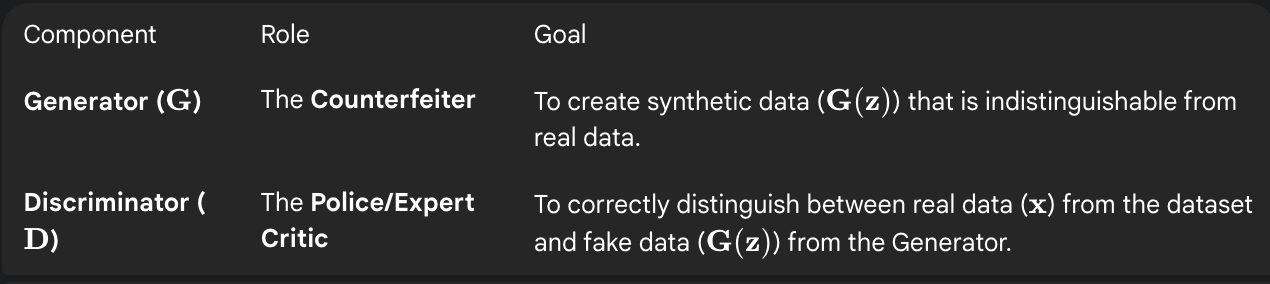

The two networks are trained simultaneously in an adversarial process: as the Generator gets better at faking, the Discriminator is forced to get better at detecting fakes, leading to a highly refined Generator capable of producing novel, realistic samples.

## 🔄 Alternating Training and Freezing Weights
The quote, "We train each model in an alternating fashion. In practical terms, when you train the discriminator, you have to freeze the weights of the discriminator," refers to the specific protocol needed to stabilize the competition.

### 1. Alternating Training
You cannot train both networks at the same time using a single loss function, because their goals are opposite. Instead, training is done in two alternating phases per iteration:

- Phase 1: Train the Discriminator (D): You update D's weights to maximize its ability to classify real data as "Real" (1) and fake data as "Fake" (0).

- Phase 2: Train the Generator (G): You update G's weights to minimize D's ability to tell its fakes are fake. G is being trained to trick D.

### 2. Freezing Weights (When Training the Generator)
The statement that you "freeze the weights of the discriminator" is accurate, but the freeze happens when you are training the Generator (G).

- When the Generator is training, its loss function is based on the output of the Discriminator.

- If you let the Discriminator's weights change at the same time, the target that the Generator is aiming for would be unstable.

- The Fix: When running G's backward pass, the Discriminator's weights are temporarily held constant, treating D simply as a fixed loss function used to guide G. This ensures G has a stable target to learn from.

### 📊 Discriminator Output and Distributions
1. Discriminator Output (Probability 0 to 1)
Yes, you are correct. The Discriminator outputs a single scalar value, usually pushed through a Sigmoid activation function, which represents the probability that the input is real.

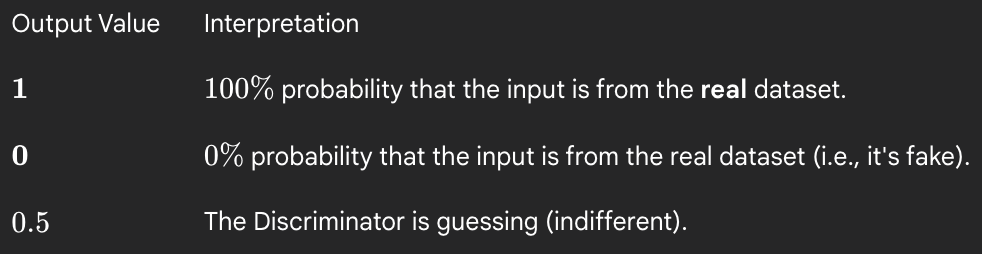

2. The Role of Distributions (Why Images are Not Just Vectors)
- The concept of "distribution" is essential for generative models.

- The Problem: The Discriminator isn't trying to remember if a specific, single image x is real. It's trying to learn the general rules, structure, and statistics of all real images.

- Data Distribution P_data: This is the underlying probability distribution that governs all possible real images. For example, P_data dictates that real images usually have smooth transitions, eyes are above the nose, and faces are generally symmetric.

- Generator's Distribution P_G: The Generator creates its own distribution of images.

- Discriminator's Goal: The Discriminator learns to define the boundaries of the P_data distribution.

- The Image as a Vector: While an image is physically represented as a high-dimensional vector of pixels, the Discriminator is learning a function to distinguish the manifold (the shape) of the P_data vector space from the P_G vector space.
The ultimate goal of the Generator is to create images so good that its distribution, P_G is mathematically identical to the distribution of the real world, P_data.


The Discriminator in a GAN doesn't figure out the data distribution P_data by memorizing every single image vector; it learns the structure, correlation, and statistical relationships embedded within the vast collection of those vectors.

That's a profound question! It gets to the heart of what a neural network actually "sees." The Discriminator in a GAN doesn't figure out the data distribution P_data by memorizing every single image vector; it learns the structure, correlation, and statistical relationships embedded within the vast collection of those vectors.

Here's how the Discriminator "learns the distribution" from image vectors:

#### 1. Learning the Data Manifold
- The set of all real images (faces, cats, etc.) doesn't fill up the entire high-dimensional pixel space; they occupy a small, complex, continuous surface within that space called the data manifold.

- The Task: The Discriminator's job is to learn the shape and boundaries of this manifold.

- Vector Interpretation: A real image vector sits exactly on this manifold, while a random noise vector sits far off it. The Discriminator learns the features that characterize this "on-manifold" property.

#### 2. Using Convolutional Filters
- Since the Discriminator is usually a Convolutional Neural Network (CNN), it learns the distribution by extracting hierarchical features:

- Early Layers (Low-Level Statistics): The first layers learn fundamental statistical correlations, such as the relationship between neighboring pixels (e.g., that smooth gradients and continuous edges are statistically common in real images, while random noise and abrupt color changes are not).

- Deep Layers (High-Level Structure): Deeper layers combine these low-level features to recognize complex, global statistics, like the texture of hair, the circularity of an eye, or the fact that a light source casts a consistent shadow across a face.

- Learning the Rules: The Discriminator doesn't memorize a face; it learns that any real image must satisfy thousands of internal consistency rules (or statistical correlations) simultaneously.

3. The Role of Backpropagation
The Discriminator refines its understanding of the distribution through adversarial training:

- Input: The Discriminator receives both Real image vectors (x) and Fake image vectors (G(z)).

- Gradient Signal:

     -  When D misclassifies a Real image as Fake, it receives a strong gradient telling it to adjust its weights to better recognize the features of "Realness."

     -  When D misclassifies a Fake image as Real, it receives a strong gradient telling it to adjust its weights to better recognize the statistical inconsistencies that define "Fakeness."

By repeatedly maximizing its score against the real data and minimizing its score against the fake data, the Discriminator implicitly constructs a highly detailed, internal model of the probability density function (P_data) that describes all possible real images. Any new vector (real or generated) is then checked against this statistical model to determine its probability of belonging to the real distribution.

# Training

One key insight is the indirect training: this basically means that the generator is not trained to minimize the distance to a specific image, but just to fool the discriminator!

The loss that occurs in this training is called adversarial loss.

When we train D, real images are labeled as 1 and fake generated images as 0. On the other hand, the ground truth label, when training the generator, is 1 for fake images (like a real image), even though the examples are fake.

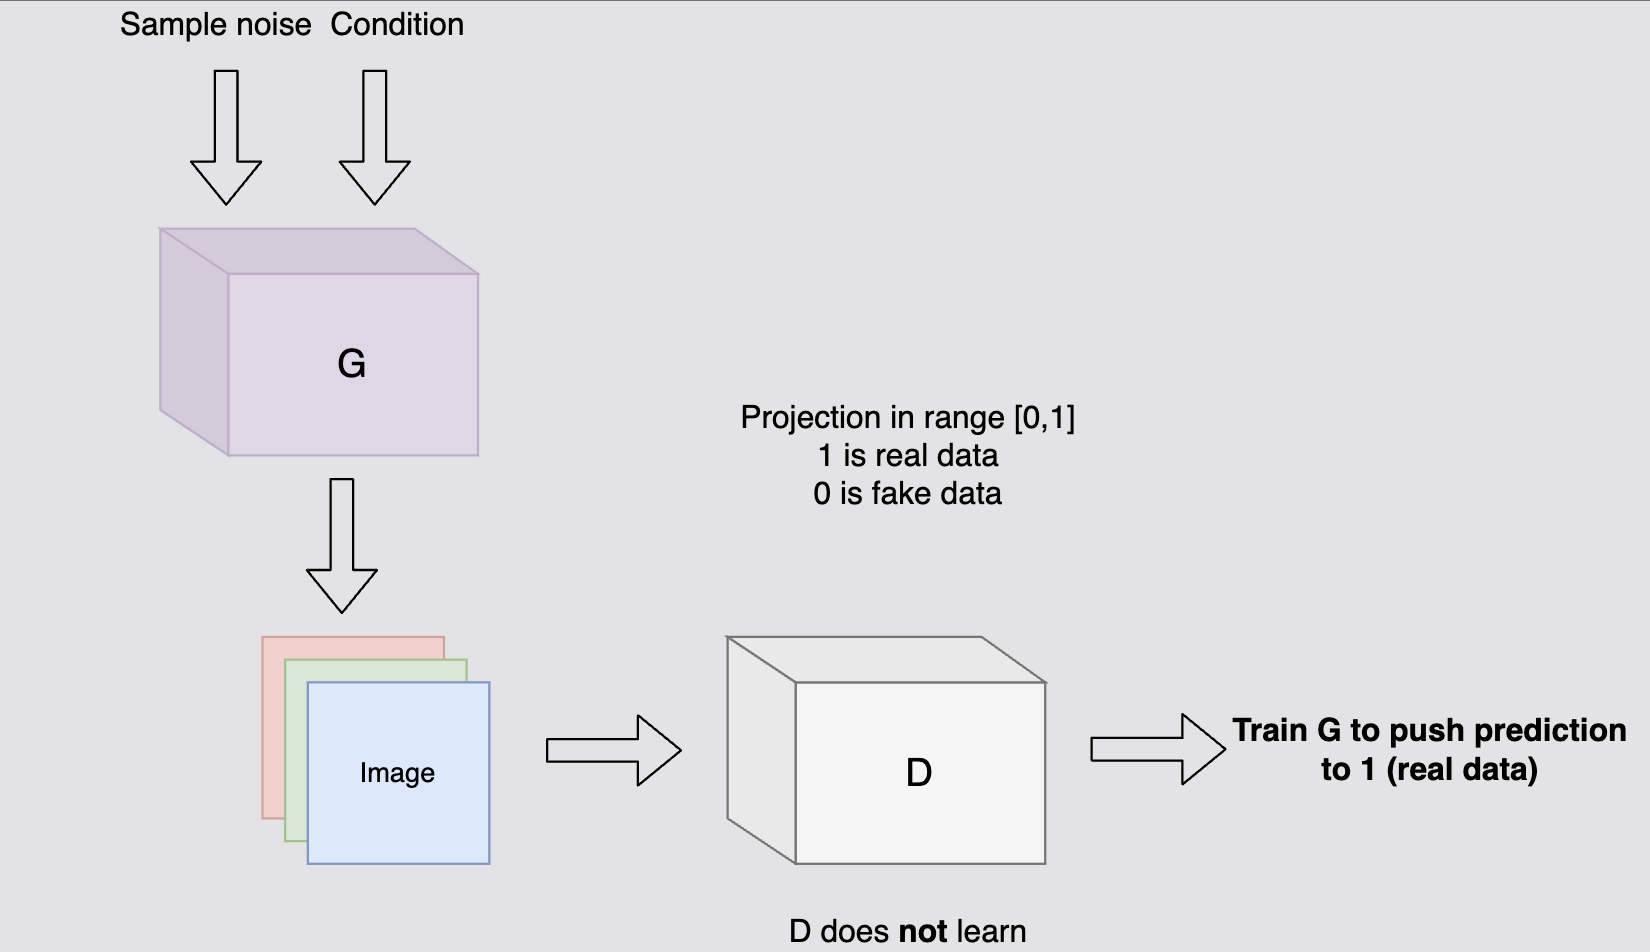

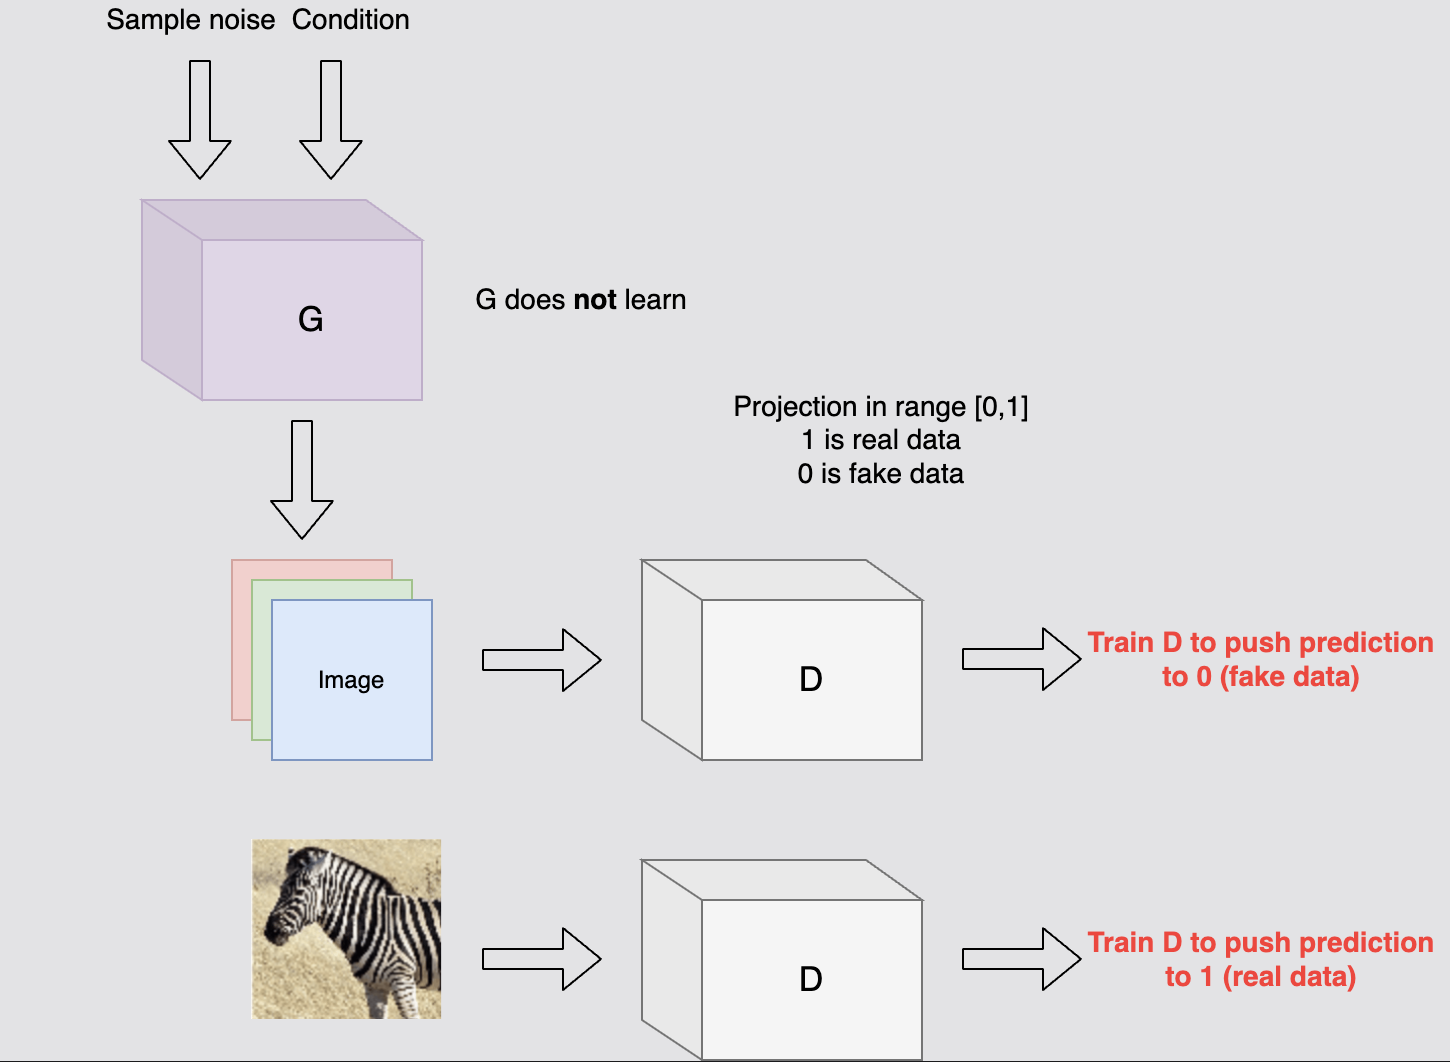

>Note that,D needs to access both real and fake data while G has no access to the real images.

## The Core Objective Function (The Minimax Game)

The first line defines the **objective function** $V(G,D)$ that guides the adversarial training of a **Generative Adversarial Network (GAN)**:

$$\min_{G} \max_{D} V(G,D) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log(1 - D(G(\mathbf{z})))]$$

This expression formalizes the **"minimax" game** between the **Generator** ($G$) and the **Discriminator** ($D$).


### 🧐 The Discriminator's Goal ($\max_{D} V$)

The Discriminator ($D$) tries to **maximize** $V(G,D)$.

* #### First Term: $\mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})]$
    * $D(\mathbf{x})$ is the Discriminator's output (probability of being real) for a **real image** $\mathbf{x}$.
    * Maximizing $\log D(\mathbf{x})$ means $D(\mathbf{x})$ should be close to **1**.
    * **Goal:** Correctly classify real data as **Real (1)**.

* #### Second Term: $\mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log(1 - D(G(\mathbf{z})))]$
    * $D(G(\mathbf{z}))$ is the probability of the **fake image** $G(\mathbf{z})$ being real.
    * Maximizing $\log(1 - D(G(\mathbf{z})))$ means $1 - D(G(\mathbf{z}))$ should be close to 1, which means $D(G(\mathbf{z}))$ should be close to **0**.
    * **Goal:** Correctly classify fake data as **Fake (0)**.


### 🎨 The Generator's Goal ($\min_{G} V$)

The Generator ($G$) tries to **minimize** $V(G,D)$.

* $G$ only controls the **second term**: $\mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log(1 - D(G(\mathbf{z})))]$.
* Minimizing this term means $\log(1 - D(G(\mathbf{z})))$ should be as small as possible. This happens when $D(G(\mathbf{z}))$ is close to **1** (since $\log(0)$ approaches $-\infty$).
* **Goal:** Create fakes that **trick $D$** into outputting **Real (1)**.


## Latents and p(z)
The latent variable z is the input to the Generator, and p(z) is the prior distribution of the latent code.

What it is: p(z) is a simple, fixed probability distribution, typically a standard normal distribution (N(0,1)) or a uniform distribution.

How it's Used: The Generator samples vectors z from this known distribution (E_ 
z∼p(z)). This simple input is the source of randomness that allows the Generator to produce varied output images.

The Generator's job is to transform this simple, known latent distribution p(z) into the complex, desired data distribution p _data(x).



## G Output Dimensionality
The statement that G outputs a "1-D vector of the image" is likely a confusion or simplification.

Input: The Generator receives a 1-D vector of noise z (e.g., length 100).

Output: The Generator must output a tensor with the same dimensions as the image it is trying to create (e.g., a 3×256×256 tensor). If the image is flattened (as required for a simple Fully Connected Network), the output would be a 1-D vector of length 3×256×256 pixels.

If it's a CNN Generator (Standard): The output is usually a 4-D tensor (Batch × Channels × Height × Width).

The D(…) function then takes this image tensor/vector and maps it down to a single scalar probability output (0 to 1).



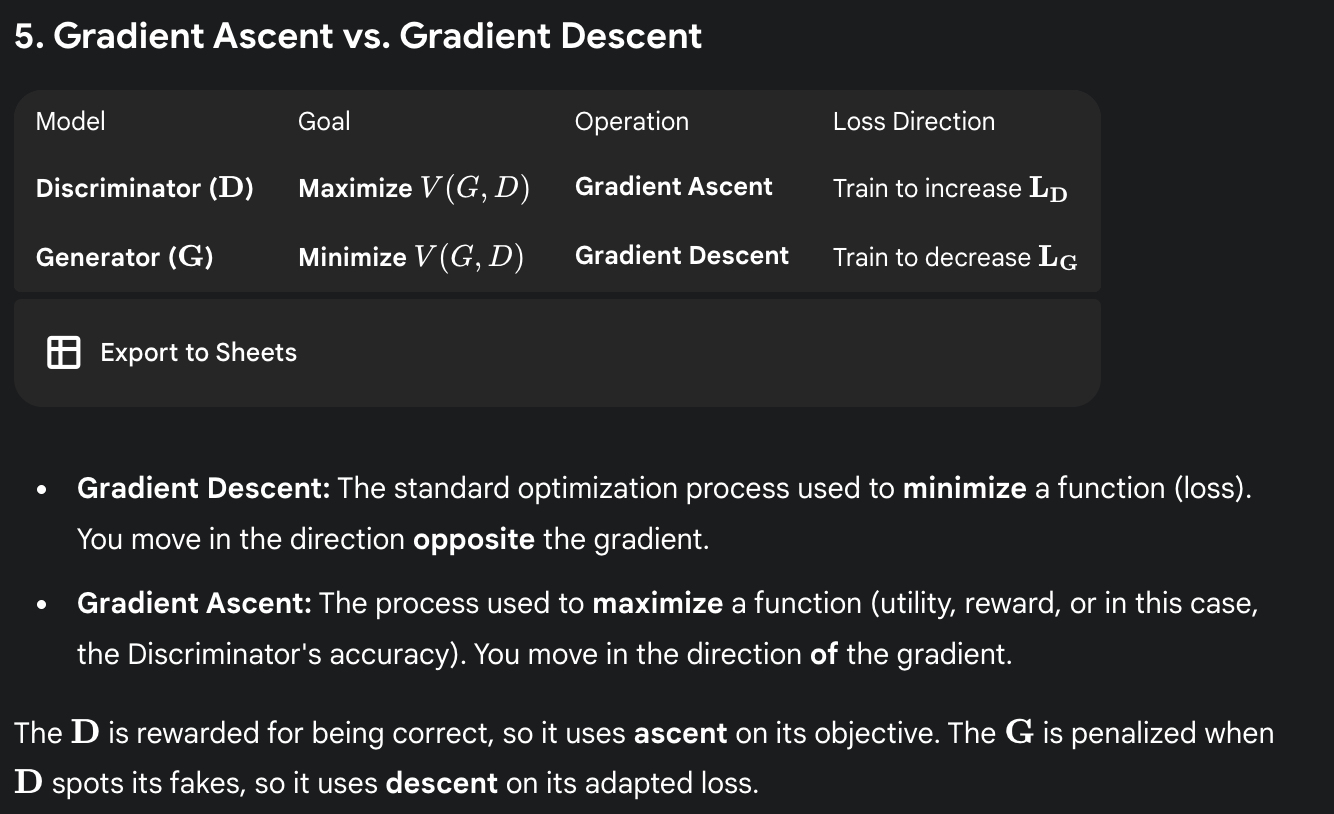

## 🎲 From Random Sample to New Image: The GAN Process

The process relies on the **Generator** ($G$) being a complex neural network that has been trained to map one specific vector space (the **latent space**) onto another specific vector space (the real image data space, $p_{\text{data}}$).

---

### 1. Sampling from the Prior Distribution $p(\mathbf{z})$

The generation of a new image starts with random sampling.

* **The Prior $p(\mathbf{z})$:** This is the fixed, simple distribution (usually a **Standard Normal Distribution, $\mathcal{N}(0,1)$**). It's called the "prior" because we define it before training.
* **The Sample $\mathbf{z}$:** The process begins by drawing a **random vector ($\mathbf{z}$)** from this distribution.
    * *Example:* If $p(\mathbf{z})$ is $\mathcal{N}(0,1)$ and $\mathbf{z}$ has a length of 100, the sampling results in a vector of 100 random numbers, each centered around 0.
* **Role:** This random vector $\mathbf{z}$ acts as the **seed** or the **DNA** for the image. It introduces the randomness needed to generate unique outputs.

---

### 2. The Generator's Mapping ($G(\mathbf{z})$)

The Generator ($G$) is a deep neural network, typically composed of **ConvTranspose2d** layers (often referred to as deconvolution or upsampling layers).

* **Input:** The 1D noise vector $\mathbf{z}$ (the seed).
* **Initial Transformation:** The Generator first takes the 1D vector $\mathbf{z}$ and passes it through one or more **fully connected (linear) layers** to transform it into a small, deep 4D tensor (e.g., $512 \times 4 \times 4$). This creates the initial, structured feature map.
* **Upsampling:** The `ConvTranspose2d` layers then take this small, deep feature map and **upscale it iteratively** (e.g., $4 \times 4 \to 8 \times 8 \to 16 \times 16 \to 32 \times 32$) while simultaneously applying learned convolutional filters.

---

### 3. Creating the Image Structure

During training, the Generator learns to interpret the numbers in the $\mathbf{z}$ vector as **high-level, abstract attributes** of the desired image.

* A value in $\mathbf{z}$ might control "hair color."
* Another value might control "head angle."

By translating these abstract values through its complex layers, the Generator outputs a final tensor that adheres to the learned statistical rules of the **real data distribution ($P_{\text{data}}$)**, resulting in a novel, realistic image.

> **In essence, the random vector $\mathbf{z}$ tells the trained Generator what kind of image to draw, and the Generator's weights tell it how to draw it realistically.**

# Develop a GAN with Pytorch

After importing our standard Pytorch modules, we will define the generator and the discriminator. Both of them are simple multi-layer networks.

## Generator
Receives as input 100-length noise vector z sampled from a distribution
Outputs a flattened image in the dimensions of the cifar10 dataset: 32×32×3=3072

## Discriminator
- The discriminator receives an input of size = 3072, which is again the flattened cifar10 image or the output of the generator.
- It outputs a scalar in [0,1].
- The binary cross-entropy loss is computed based on the output of the discriminator and the data label.
- Note that when we train the discriminator, the generated images have the label of 0, and the real images have the label of 1.



> usually in GANs the D & G are both ConvNets not MLP - for preserving spatial relationships.

In [4]:
import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data import DataLoader

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 3072
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 3072

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## Train the discriminator
For the discriminator, we have:

1. Run a forward and backward pass on real training data.
2. Run a forward and backward pass on fake training data.
3. Update the weights.
4. Train the generator
   
For the generator:

1. Generate a noise vector.
2. Perform another pass on the discriminator with the fake data.
3. Calculate the generator’s loss and update the weights.


In [5]:
def train_discriminator(discriminator, optimizer, real_data, fake_data, loss):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(discriminator, optimizer, fake_data, loss):
    # Sample noise and generate fake data
    N = fake_data.size(0)  
    # Reset gradients
    optimizer.zero_grad() 
    # Calculate error and backpropagate
    prediction = discriminator(fake_data)  
    error = loss(prediction, ones_target(N))
    error.backward() 
    # Update weights with gradients 
    optimizer.step()  
    # Return error
    return error

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data


def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

def images_to_vectors(images):
    return images.view(images.size(0), -1)

For each batch of data:

1. Train the discriminator with both real data and fake data produced from the generator.
2. Train the generator.

In [6]:
def load_data():

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root='../cifar10', train=True,
                                            download=True, transform=transform,)
    # training_data = torch.utils.data.Subset(trainset,range(0,10,1))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=False, num_workers=1)

    return trainloader



def gan():
    # Models, optimizers and losses
    discriminator = DiscriminatorNet()
    generator = GeneratorNet()
    loss_d = nn.BCELoss()
    loss_g = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), 0.0002)
    g_optimizer = optim.Adam(generator.parameters(), 0.0002)

    data_loader= load_data()

    for epoch in range(1):
        for n_batch, data in enumerate(data_loader):

            (real_batch, labels) = data
            N = real_batch.size(0)

            # 1. Train Discriminator
            real_data = images_to_vectors(real_batch)

            # Generate fake data and detach so gradients are not calculated for generator)
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data).detach()

            d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator, d_optimizer, real_data,
                                                                          fake_data,
                                                                          loss_d)

            # 2. Train Generator

            # Generate fake data TO train Generator
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data)
            # Train G
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss_g)  # Log batch error


            print(f'derror:{d_error}, gerror:{g_error}')

if __name__ == "__main__":
    gan()

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s] 


derror:1.3879376649856567, gerror:0.6853064298629761
derror:1.3612732887268066, gerror:0.679140567779541
derror:1.3224656581878662, gerror:0.6778188347816467
derror:1.28083074092865, gerror:0.6729260087013245
derror:1.2785446643829346, gerror:0.666649341583252
derror:1.2608188390731812, gerror:0.6629944443702698
derror:1.0934730768203735, gerror:0.6474989652633667
derror:1.2056447267532349, gerror:0.6310794353485107
derror:1.196151852607727, gerror:0.5968227982521057
derror:1.241584062576294, gerror:0.5979716777801514
derror:1.3968225717544556, gerror:0.5489321947097778
derror:1.1504861116409302, gerror:0.5538899898529053
derror:1.3459361791610718, gerror:0.5036718249320984
derror:1.3489948511123657, gerror:0.4888444244861603
derror:1.2235090732574463, gerror:0.45754849910736084
derror:1.471132516860962, gerror:0.4864988923072815
derror:1.40623140335083, gerror:0.4446057379245758
derror:1.2451471090316772, gerror:0.4683481454849243
derror:1.4282835721969604, gerror:0.5162774324417114
d

The line of PyTorch code `fake_data = generator(latent_space_data).detach()` serves two crucial purposes when training a Generative Adversarial Network (GAN):

1. Generates Fake Data: It runs the forward pass of the Generator (G) to create synthetic images.

2. Stops Gradient Flow: It prevents the gradients from the subsequent Discriminator loss calculation from flowing back to and updating the Generator's weights.

Here is a breakdown of the function of each part of the line, which typically occurs during the Discriminator training phase in a GAN.

1. `generator(latent_space_data)`
    This part is the standard forward pass for the Generator (G):
    
    `latent_space_data`: This is the 1D noise vector (z) sampled from the prior distribution (N(0,1)). It is the input "seed" for the image.
    
    `generator(...)`: The Generator network takes the z vector and transforms it (via its nn.Linear layers) into the output, which is the flattened fake image.

2. `.detach()`
This is the most critical function of the line and is essential for the adversarial training process.

    - What it does: The `.detach()` method returns a new tensor that shares the same data as the original output, but severs the connection to the computational graph.
    
    - Why it's needed: When you train the Discriminator (D), you need to calculate a loss and then run loss.backward() to update D's weights. However, the loss depends on the output of G. Without .detach(), the gradient would flow backward through D and continue all the way back into G, causing G's weights to update prematurely during D's optimization step.
    
    - The Goal: By using .detach(), you freeze the Generator during the Discriminator's training phase, treating the fake_data as a constant input rather than the result of a trainable function. This fulfills the requirement that D is trained against a fixed version of G in that specific step.
    
    > In summary, the line generates the fake samples needed for the Discriminator's training step and ensures that the Generator's parameters are isolated and not accidentally updated.

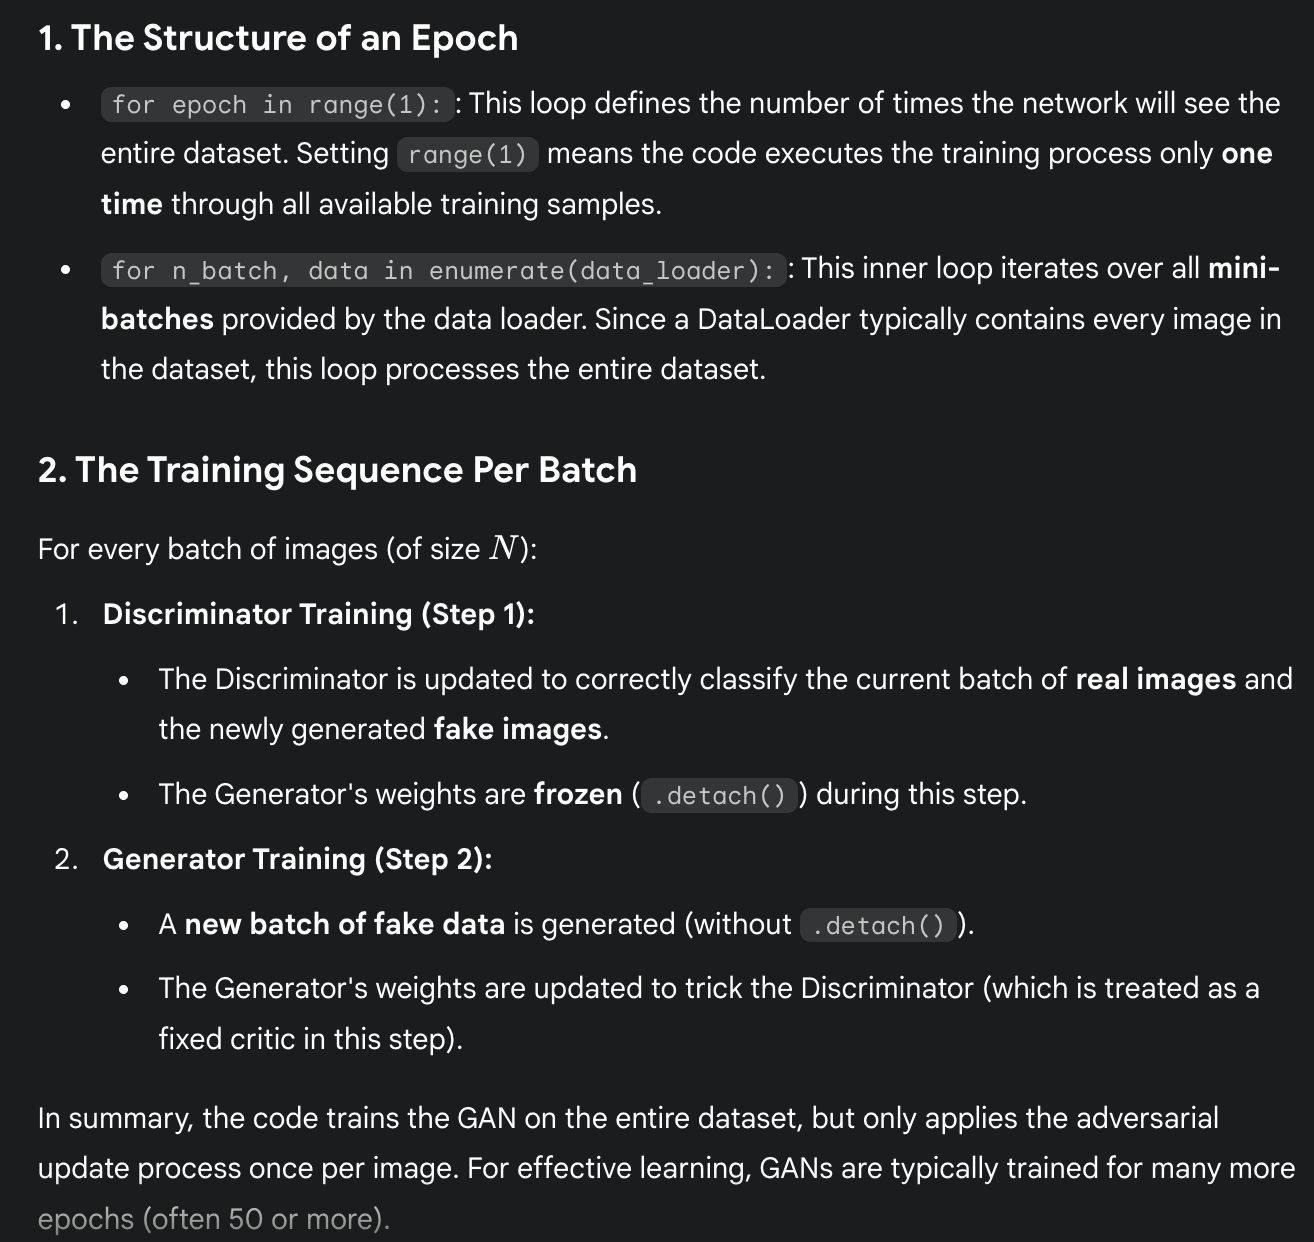